# Toy example for demonstration of spurious pixel removal

__last update__: 10/11/21

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, TwoSlopeNorm
%matplotlib inline
plt.rc('image', interpolation='none')

from herculens.Util.jax_util import WaveletTransform
from herculens.Analysis.plot import Plotter
plotter = Plotter()

In [2]:
num_pix = 50
xx, yy = np.meshgrid(np.arange(num_pix), np.arange(num_pix))
image = 10 + 10*np.exp(-((xx - np.mean(xx))**2 + (yy - np.mean(yy))**2)/10**2)

# simulate spurious pixels
np.random.seed(8)
spurious_pixels = np.random.randn(num_pix, num_pix)
spurious_pixels[spurious_pixels < 1.8] = 0.

degraded_image = image + spurious_pixels

In [3]:
def hard_threshold(img, thresh):
    img_c = img.copy()
    img_c[img < thresh] = 0.
    return img_c

def soft_threshold(img, thresh):
    return np.sign(img) * np.maximum(np.abs(img) - thresh, 0.)

bl_transform = WaveletTransform(1, wavelet_type='battle-lemarie-3')
st_transform = WaveletTransform(int(np.log2(num_pix)), wavelet_type='starlet')
recovered_image = degraded_image.copy()

# Battle-Lemarié filtering
coeffs = np.array(bl_transform.decompose(degraded_image))
coeffs[0, :, :] = hard_threshold(coeffs[0, :, :], 10)
recovered_image = bl_transform.reconstruct(coeffs)

# starlet filtering
coeffs = np.array(st_transform.decompose(recovered_image))
coeffs[0, :, :] = hard_threshold(coeffs[0, :, :], 10)
recovered_image = st_transform.reconstruct(coeffs)

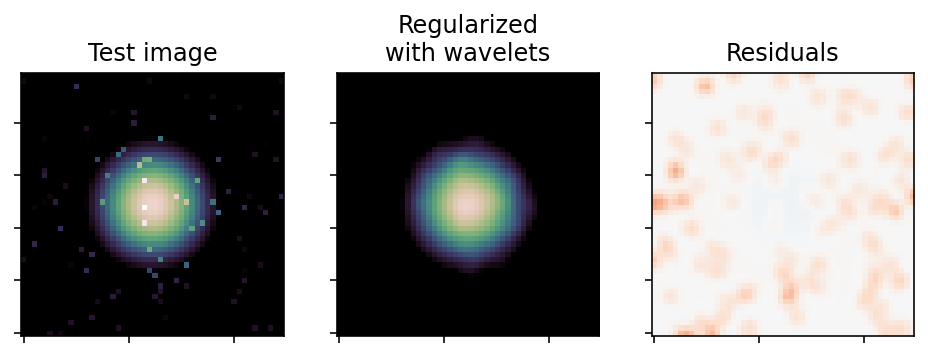

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4.5))
ax = axes[0]
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("Test image", fontsize=12)
im = ax.imshow(degraded_image, origin='lower', vmin=12, vmax=degraded_image.max(), cmap=plotter.cmap_flux, rasterized=True)
#plt.colorbar(im, ax=ax)
ax = axes[1]
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("Regularized\nwith wavelets", fontsize=12)
im = ax.imshow(recovered_image, origin='lower', vmin=12, vmax=degraded_image.max(), cmap=plotter.cmap_flux, rasterized=True)
#plt.colorbar(im, ax=ax)
ax = axes[2]
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("Residuals", fontsize=12)
im = ax.imshow((recovered_image - image) / image, origin='lower', 
               vmin=-0.2, vmax=0.2, cmap=plotter.cmap_res, rasterized=True)
#plt.colorbar(im, ax=ax)
plt.show()

In [5]:
fig_name = 'demo_spurious_pixels.pdf'
fig_path = os.path.join('figures', fig_name)
fig.savefig(fig_path, dpi=100, bbox_inches='tight')